In [1]:
import os, cv2, geojson
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import cm, colors
from pyproj import Proj
UTM_10_PROJ = Proj("+proj=utm +zone=10N, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [2]:
def stddev_above_threshold(x,y,window_size, threshold,im):
    r = im[x*window_size:(x+1)*window_size, y*window_size:(y+1)*window_size, 0:2]
    return r.std() > threshold
def compressed_green(x,y,window_size,green_mask):
    r = green_mask[x*window_size:(x+1)*window_size, y*window_size:(y+1)*window_size]
    return r.mean() > 128
def convert_to_lon_lat(polygon_raw, x_res, y_res, utm_10_top_left_coord):
    polygon_processed = [[x[0][0]*x_res+utm_10_top_left_coord[0],x[0][1]*y_res+utm_10_top_left_coord[1]] for x in polygon_raw]
    projected = [UTM_10_PROJ(x[0], x[1], inverse=True) for x in polygon_processed]
    head = projected[0]
    projected.append(head)
    return projected


In [3]:
def extract_tree_cover_from_tif_tfw(filename, n, g, stddev_threshold, darker_colour_threshold, lighter_colour_threshold):
    x_res = 0.0
    y_res = 0.0
    x_coord = 0.0
    y_coord = 0.0

    with open(filename+".tfw", mode = "r") as tfw_file:
        x_res = float(tfw_file.readline())
        tfw_file.readline()
        tfw_file.readline()
        y_res = float(tfw_file.readline())
        x_coord = float(tfw_file.readline())
        y_coord = float(tfw_file.readline())
        
    image = cv2.imread(filename+'.tif')
 #   plt.imshow(image)
    kernel = np.ones((g,g),np.float32)/(g*g)
    blurred_image = cv2.filter2D(image,-1,kernel)
    hsv_blurred_image = cv2.cvtColor(blurred_image, cv2.COLOR_RGB2HSV)
    plt.imshow(cv2.cvtColor(hsv_blurred_image, cv2.COLOR_HSV2RGB))
    mask = cv2.inRange(hsv_blurred_image, darker_colour_threshold, lighter_colour_threshold)
    blurred_image = ndimage.gaussian_filter(image, sigma=2)
    stddev_array = np.array([stddev_above_threshold(i//n,i%n,g,stddev_threshold,blurred_image) for i in range(0,n**2)]).reshape(n,n)
    compressed_green_array = np.array([compressed_green(i//n,i%n,g,mask) for i in range(0,n**2)]).reshape(n,n)
    #plt.imshow(compressed_green_array, cmap=plt.cm.gray)
    green_stddev_array = np.array([compressed_green_array[i//n,i%n] and stddev_array[i//n,i%n] for i in range(0,n**2)]).reshape(n,n)
    close_img = ndimage.binary_closing(green_stddev_array)
    open_img = ndimage.binary_opening(close_img)
    thresh = np.array(open_img*255,dtype=np.uint8)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print("Found "+str(len(contours))+" contours in " + filename + ".tif")

    feature_list = []
    for c in contours:
        lon_lat = convert_to_lon_lat(c*g,x_res,y_res,[x_coord,y_coord])
        feature_list.append(geojson.Feature(geometry=geojson.Polygon([lon_lat])))
    feature_collection = geojson.FeatureCollection(feature_list)

    with open(filename + ".geojson", mode = "w") as out_file:
        geojson.dump(feature_collection,out_file)

Found 220 contours in 483E_5454N.tif


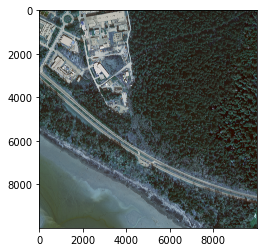

In [4]:
# size of image
width = 10000
# granularity of subimages
g = 20
# number of subimages
n = int(width / g)
stddev_threshold = 7
dark_green = (55/360*255,0, 0)
light_green = (180/360*255, 255, 150)

#Start extraction
directory = "/home/jonathan/ubc/capstone/orthophoto/2020"
os.chdir(directory)
extract_tree_cover_from_tif_tfw("483E_5454N",n,g,stddev_threshold,dark_green,light_green)
# for file in os.listdir(directory):
#      if file.endswith(".tif"): 
#         extract_tree_cover_from_tif_tfw(file[:-4],n,g,stddev_threshold,dark_green,light_green)